### MASKED + WEIGHTED + VARIANCE + RANDOM + SYMMETRIZATION $\kappa$ MAP

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from helper import preprocess_catalog_galactic
from helper import load_catalog
from helper import symmetrize_map
from helper import radial_profile

In [109]:
# --- Settings ---
catalog, region = "LRG", "NGC"
real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [110]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [111]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

In [114]:
def assign_jackknife_regions_healpix(catalog, rand_cat, nside=10, threshold=0.9):
    rand_coord = SkyCoord(ra=rand_cat['RA']*u.deg, dec=rand_cat['DEC']*u.deg)
    rand_pix = hp.ang2pix(nside, np.radians(90 - rand_coord.dec.value), np.radians(rand_coord.ra.value))

    unique, counts = np.unique(rand_pix, return_counts=True)
    mean_density = np.mean(counts)
    good_pix = unique[counts > threshold * mean_density]

    gal_coord = SkyCoord(ra=catalog['RA']*u.deg, dec=catalog['DEC']*u.deg)
    gal_pix = hp.ang2pix(nside, np.radians(90 - gal_coord.dec.value), np.radians(gal_coord.ra.value))

    mask = np.isin(gal_pix, good_pix)
    return gal_pix[mask], mask

In [116]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    # --- Preprocess only valid galaxies and convert to Galactic ---
    l_arr, b_arr, D_arr, data = preprocess_catalog_galactic(data)
    weights = weights[:len(data)]  # Ensure weights match filtered data

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_wk2 += w * κ_vals**2
        sum_w += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [117]:
def jackknife_stack_healpix(data, weights, rand_cat, nside=10, threshold=0.9):
    jk_regions, valid_mask = assign_jackknife_regions_healpix(data, rand_cat, nside, threshold)
    data, weights = data[valid_mask], weights[valid_mask]
    unique_regions = np.unique(jk_regions)

    kappa_jk = []

    for reg in tqdm(unique_regions, desc="Jackknife (HEALPix)"):
        mask_jk = jk_regions != reg
        data_jk = data[mask_jk]
        weights_jk = weights[mask_jk]
        kappa, _, _ = stack_kappa(data_jk, weights_jk, f"JK-{reg}")
        kappa_jk.append(kappa)

    kappa_jk = np.array(kappa_jk)
    kappa_mean = np.mean(kappa_jk, axis=0)
    kappa_err = np.sqrt((len(kappa_jk) - 1) / len(kappa_jk) * np.sum((kappa_jk - kappa_mean)**2, axis=0))

    return kappa_mean, kappa_err

In [118]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
    plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [120]:
# --- Run all ---
data_real, w_real = load_catalog(real_file, weights=True)
data_rand, w_rand = load_catalog(rand_file, random_fraction=0.10)

# Jackknife real galaxies
kappa_real, sigma_real = jackknife_stack_healpix(data_real, w_real, data_rand, nside=10)
sn_real = np.zeros_like(kappa_real)
valid = sigma_real > 0
sn_real[valid] = kappa_real[valid] / sigma_real[valid]
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Jackknife (HEALPix):   0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

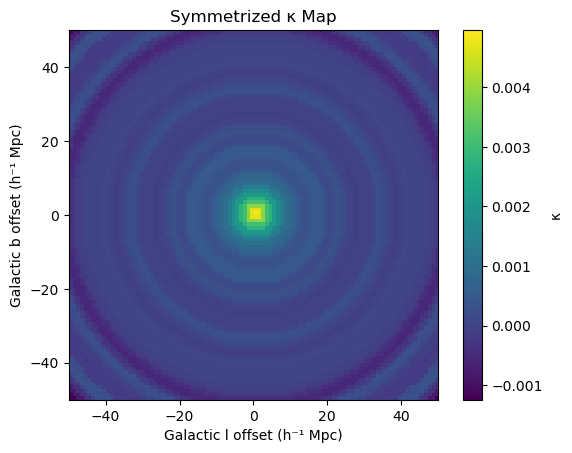

In [95]:
kappa_sym = symmetrize_map(kappa_sub)
plot_map(kappa_sym, "Symmetrized κ Map", cmap='viridis')

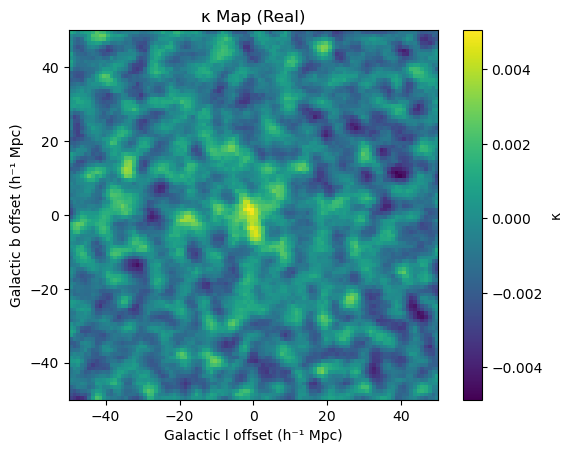

In [96]:
# --- Plots ---
plot_map(kappa_real, "κ Map (Real)")

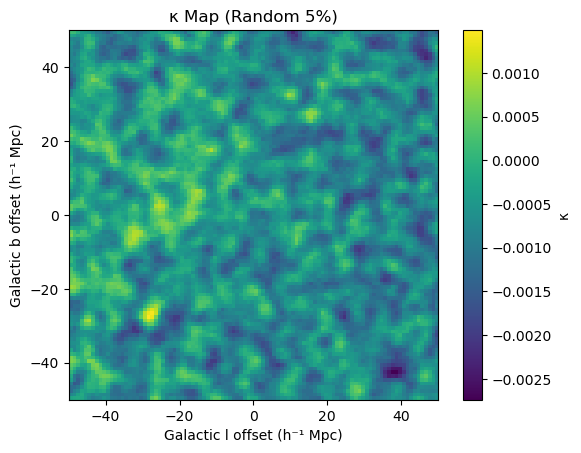

In [97]:
plot_map(kappa_rand, "κ Map (Random 5%)")

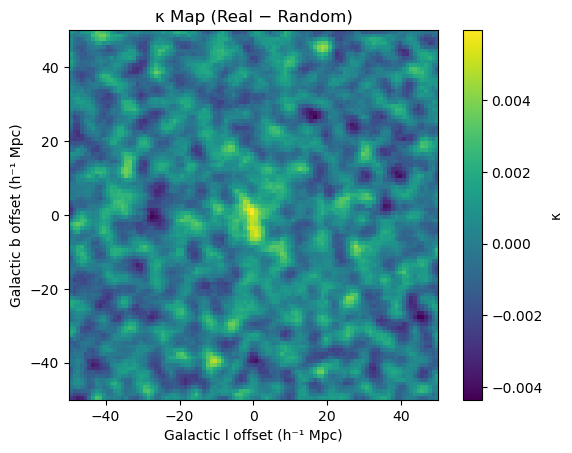

In [98]:
plot_map(kappa_sub, "κ Map (Real − Random)")

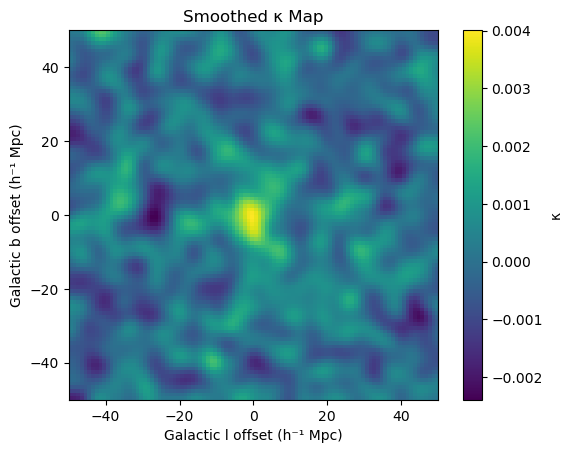

In [99]:
plot_map(kappa_smooth, "Smoothed κ Map", cmap='viridis')

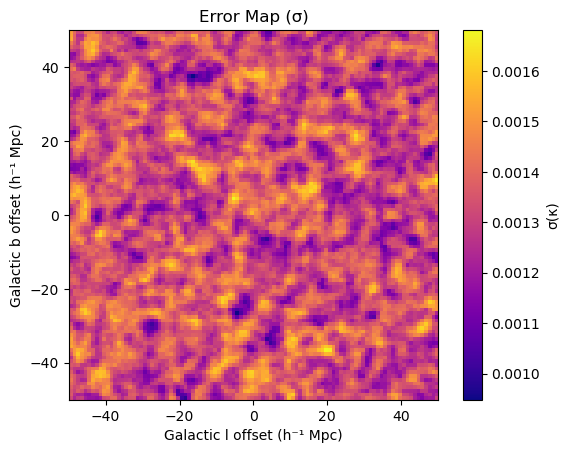

In [100]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

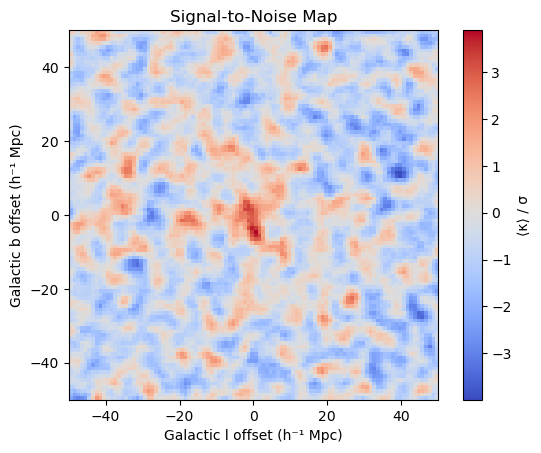

In [101]:
plot_map(sn_real, "Signal-to-Noise Map", cmap='coolwarm', label='⟨κ⟩ / σ')

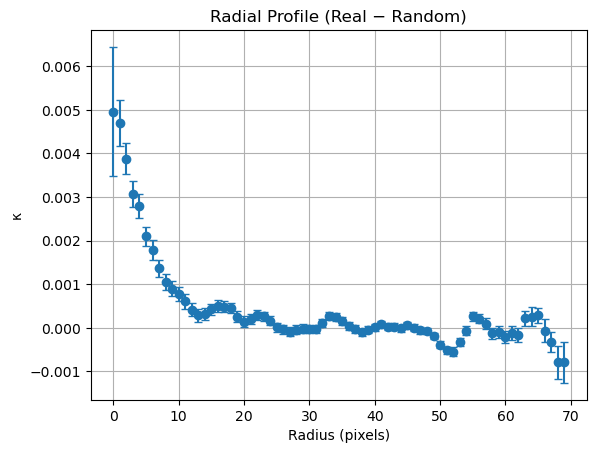

In [102]:
profile, errs = radial_profile(kappa_sub, sigma_real, "Radial Profile (Real − Random)", zoom=70)
np.save("old_sub_radial.npy", profile)

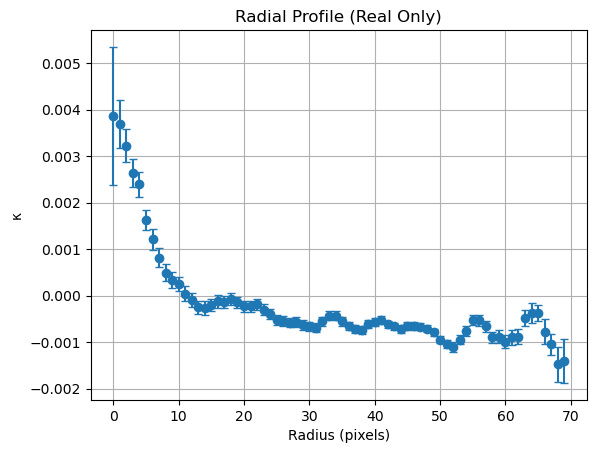

In [103]:
profile, errs = radial_profile(kappa_real, sigma_real, "Radial Profile (Real Only)", zoom=70)
np.save("old_real_radial.npy", profile)

<function matplotlib.pyplot.show(close=None, block=None)>

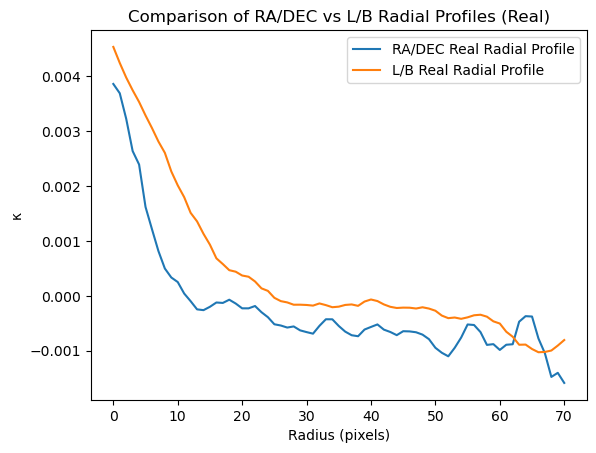

In [104]:
old_real_radial = np.load("old_real_radial.npy")
new_real_radial = np.load("new_real_radial.npy")
plt.plot(old_real_radial, label='RA/DEC Real Radial Profile')
plt.plot(new_real_radial, label='L/B Real Radial Profile')
plt.legend()
plt.title("Comparison of RA/DEC vs L/B Radial Profiles (Real)")
plt.xlabel("Radius (pixels)")
plt.ylabel("κ")
plt.show

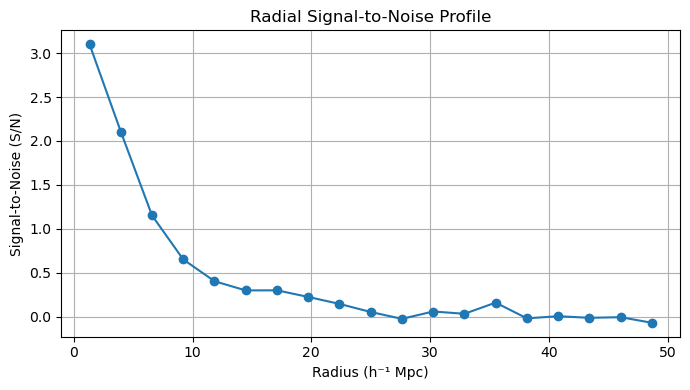

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Use your existing stacked maps here:
kappa_mean = kappa_sub       # 2D array, shape (grid_size, grid_size)
kappa_sigma = sigma_real     # 2D array, same shape

grid_size = kappa_mean.shape[0]  # e.g. 100
box_size_hmpc = 100  # your box size in h^-1 Mpc

# Create coordinate grids in Mpc
x = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
y = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
X, Y = np.meshgrid(x, y)

# Compute radius from center in Mpc
R = np.sqrt(X**2 + Y**2)

# Flatten arrays for binning
r_flat = R.ravel()
signal_flat = kappa_mean.ravel()
sigma_flat = kappa_sigma.ravel()

# Define radial bins (e.g., 20 bins up to 50 Mpc)
bin_edges = np.linspace(0, box_size_hmpc/2, 20)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Digitize radii to bins
inds = np.digitize(r_flat, bin_edges)

# Compute S/N per bin
sn_profile = []
for i in range(1, len(bin_edges)):
    in_bin = (inds == i)
    if np.any(in_bin):
        mean_signal = np.mean(signal_flat[in_bin])
        mean_sigma = np.sqrt(np.mean(sigma_flat[in_bin]**2))
        sn_profile.append(mean_signal / mean_sigma if mean_sigma > 0 else 0)
    else:
        sn_profile.append(0)

# Plot radial S/N profile
plt.figure(figsize=(7,4))
plt.plot(bin_centers, sn_profile, marker='o')
plt.xlabel('Radius (h⁻¹ Mpc)')
plt.ylabel('Signal-to-Noise (S/N)')
plt.title('Radial Signal-to-Noise Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
# --- Diagnostics ---
print("Diagnostics:")
print(f"κ min: {np.min(kappa_sub):.4g}, max: {np.max(kappa_sub):.4g}")
print(f"σ min: {np.min(sigma_real):.4g}, max: {np.max(sigma_real):.4g}")
print(f"S/N min: {np.min(sn_real):.4g}, max: {np.max(sn_real):.4g}")

Diagnostics:
κ min: -0.004352, max: 0.005958
σ min: 0.0009483, max: 0.001681
S/N min: -3.998, max: 3.905
